<h1 style="color:red; text-align:center; text-decoration:underline;">Autoencodeurs : Réduction de Dimension Non Linéaire avec PyTorch</h1>




Ce notebook montre comment construire un **autoencodeur simple en PyTorch** pour réduire la dimensionnalité d'un jeu de données non linéaire (Swiss Roll).

L’objectif est de comprimer des données 3D en 2D via un encodeur, puis de les reconstruire via un décodeur.


## 📦 Importation des bibliothèques

On importe PyTorch, NumPy, Matplotlib, et les outils de génération de données depuis `sklearn`. Ces bibliothèques sont essentielles pour le traitement, l’apprentissage et la visualisation.


In [1]:
import torch
from torch import nn, optim
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler

Ici, j’utilise l’exemple du Swiss Roll et je le réduis de 3 dimensions à 2 dimensions.

## 🌀 Génération du Swiss Roll (jeu de données 3D)

Nous générons ici un ensemble de données en forme de "Swiss Roll", très utilisé pour tester les algorithmes de réduction de dimension.  
Les points sont colorés selon leur position pour mieux visualiser la structure.


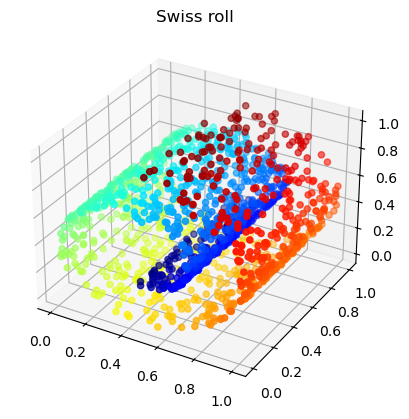

In [4]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

n_samples = 1500
noise = 0.05
X, colors = make_swiss_roll(n_samples, noise=noise)
X = MinMaxScaler().fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Swiss roll')
plt.show()

## 🎯 Préparation des données pour le modèle

On convertit le jeu de données `X` en tenseur PyTorch et on le transfère vers le GPU si disponible.


In [ ]:
x = torch.from_numpy(X).to(device)

## 🏗️ Définition de l’autoencodeur

Création d’un réseau de neurones avec :
- un **encodeur** (3D → 2D)
- un **décodeur** (2D → 3D)

Des couches `Dropout` et `BatchNorm` sont ajoutées pour améliorer la généralisation.


In [5]:

class Autoencoder(nn.Module):
    """Makes the main denoising auto

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
encoder = Autoencoder(in_shape=3, enc_shape=2).double().to(device)

error = nn.MSELoss()

optimizer = optim.Adam(encoder.parameters())

## 🔁 Fonction d’entraînement du modèle

Fonction `train(...)` pour exécuter :
- propagation avant
- calcul de la perte
- rétropropagation
- mise à jour des poids

La perte est affichée tous les 10% des époques.


In [6]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

Vous pouvez relancer cette fonction ou simplement augmenter le nombre d’époques. Le dropout a été ajouté pour réduire le bruit, sinon le modèle serait très sensible aux variations des données d’entrée.

## 🧪 Entraînement du modèle

Lancement de l’apprentissage pour **5000 époques**.  
Le modèle apprend à compresser et reconstruire les données 3D d’entrée.


In [7]:
train(encoder, error, optimizer, 5000, x)

epoch 500 	 Loss: 0.01089
epoch 1000 	 Loss: 0.008536
epoch 1500 	 Loss: 0.007662
epoch 2000 	 Loss: 0.006759
epoch 2500 	 Loss: 0.006297
epoch 3000 	 Loss: 0.005817
epoch 3500 	 Loss: 0.005492
epoch 4000 	 Loss: 0.005504
epoch 4500 	 Loss: 0.005273
epoch 5000 	 Loss: 0.005237


## 🔍 Encodage et Décodage des données

Après l’entraînement :
- les données sont compressées (encodées) en 2D
- puis reconstruites (décodées) en 3D
- on mesure l’erreur quadratique moyenne (MSE)


In [8]:
with torch.no_grad():
    encoded = encoder.encode(x)
    decoded = encoder.decode(encoded)
    mse = error(decoded, x).item()
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

## 📊 Visualisation des données encodées (2D)

Affichage des points encodés (compression de 3D à 2D).  
Cela permet de voir comment le modèle réorganise les données dans un espace réduit.


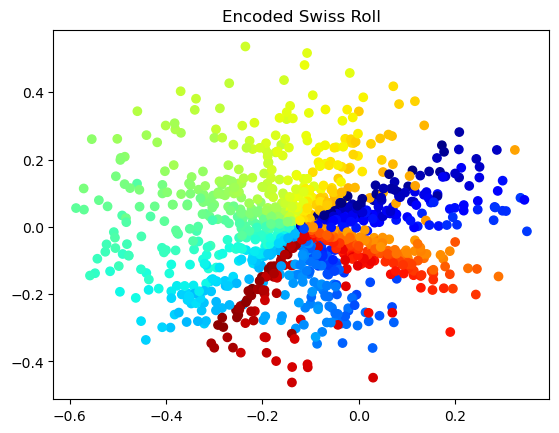

In [35]:
plt.scatter(enc[:, 0], enc[:, 1], c=colors, cmap=plt.cm.jet)
plt.title('Encoded Swiss Roll')
plt.show()

## 🧱 Visualisation 3D : original vs reconstruit

Deux graphes 3D :
- à gauche : Swiss Roll original
- à droite : Swiss Roll reconstruit par l’autoencodeur

Cela permet d’évaluer la qualité de reconstruction visuelle.


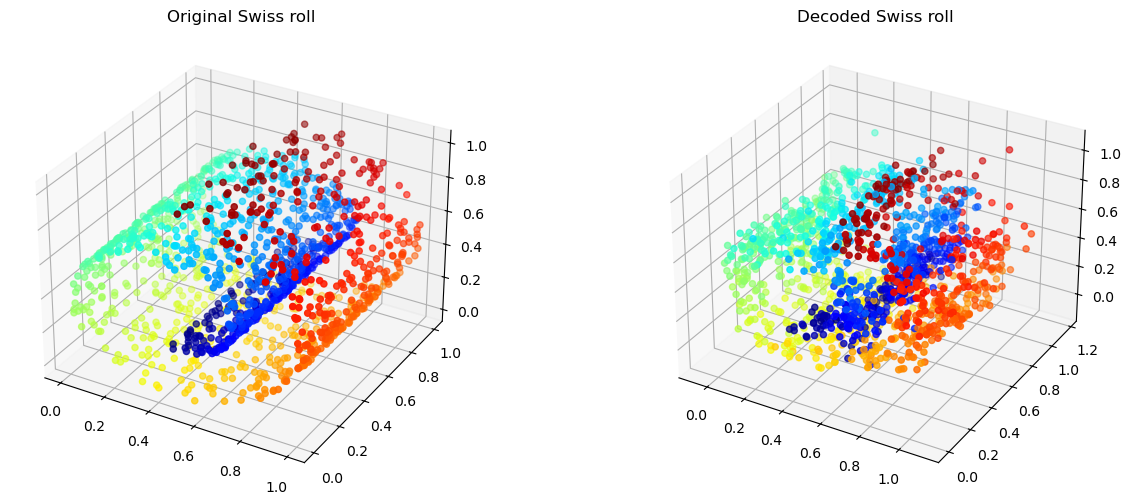

Root mean squared error: 0.07149


In [36]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Original Swiss roll')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(dec[:,0], dec[:,1], dec[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Decoded Swiss roll')
plt.show()

print(f'Root mean squared error: {np.sqrt(mse):.4g}')

Il y a évidemment des pertes de variance dues à la réduction de dimension, mais la reconstruction reste assez intéressante. Voici comment le modèle réagit à un autre Swiss Roll.

## 🔄 Test sur de nouvelles données Swiss Roll

Le modèle est testé sur un **nouveau jeu Swiss Roll** avec plus de bruit.  
On évalue la capacité de **généralisation** de l’autoencodeur sur des données jamais vues.


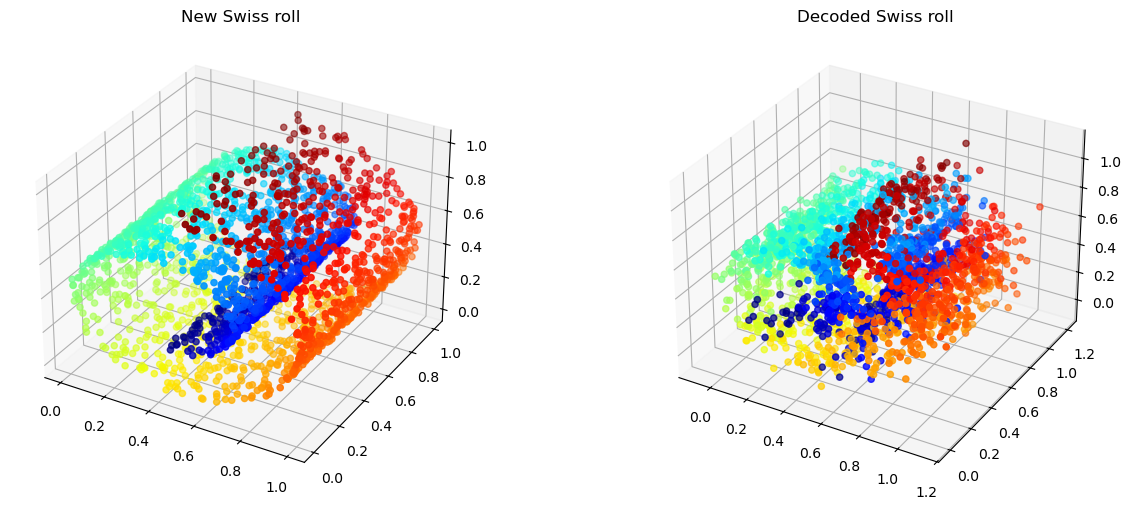

Root mean squared error: 0.08499


In [38]:
n_samples = 2500
noise = 0.1
X, colors = make_swiss_roll(n_samples, noise=noise)

X = MinMaxScaler().fit_transform(X)

x = torch.from_numpy(X).to(device)

with torch.no_grad():
    encoded = encoder.encode(x)
    decoded = encoder.decode(encoded)
    mse = error(decoded, x).item()
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, cmap=plt.cm.jet)
plt.title('New Swiss roll')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(dec[:,0], dec[:,1], dec[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Decoded Swiss roll')
plt.show()

print(f'Root mean squared error: {np.sqrt(mse):.4g}')

<h3 style="color:#0056b3; text-decoration:underline;">Résultat et Interprétation</h3>

L’autoencodeur a été entraîné pendant 5000 époques sur un Swiss Roll généré artificiellement.  
Les **données encodées en 2D** conservent une organisation cohérente, ce qui témoigne d’une compression efficace et informative.  
À la sortie du décodeur, la **reconstruction 3D** se rapproche visuellement de la forme originale, malgré une légère perte de variance, notamment due à la compression de l’information dans l’espace latent.

La **reconstruction reste fidèle à la structure globale** du Swiss Roll, même sur des jeux de données plus bruités.  
Cela démontre la capacité de l’autoencodeur à capturer les **caractéristiques intrinsèques non linéaires** du jeu de données tout en assurant une généralisation satisfaisante.

Ce test valide l’usage des autoencodeurs pour des tâches de **réduction de dimension non linéaire**, avec des applications concrètes en compression, visualisation, et prétraitement de données complexes.
